In [2]:
# To calculate implied volatility
import mibian as m

# For data manipulation and mathematical function
import pandas as pd
import numpy as np

# To plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

In [3]:
# Read CSV
nifty_data = pd.read_csv('/Users/liliaromanova/Downloads/OTSI-Resources/data_modules/Nifty.csv')

# Все колонки с датами приводятся в нужный формат данных

# Convert the date fields into pandas datetime object
nifty_data.date = pd.to_datetime(nifty_data.date)
nifty_data.near_month_expiry = pd.to_datetime(nifty_data.near_month_expiry)
nifty_data.far_month_expiry = pd.to_datetime(nifty_data.far_month_expiry)

nifty_data.index = nifty_data.date

nifty_data.head()

,symbol,date,fut_near_month_close,fut_far_month_close,strike_price,near_month_expiry,LTP_near_month,far_month_expiry,LTP_far_month
date,,,,,,,,,
2017-08-28,NIFTY,2017-08-28,9950.80,9980.65,9800,2017-09-28,226.45,2017-10-26,293.6
2017-08-29,NIFTY,2017-08-29,9829.40,9860.15,9800,2017-09-28,150.80,2017-10-26,219.7
2017-08-30,NIFTY,2017-08-30,9912.45,9939.75,9800,2017-09-28,191.20,2017-10-26,259.7
2017-08-31,NIFTY,2017-08-31,9937.20,9963.35,9800,2017-09-28,201.85,2017-10-26,266.2
2017-09-01,NIFTY,2017-09-01,10007.30,10034.20,9800,2017-09-28,251.50,2017-10-26,312.3


In [4]:
# Первым шагом расчитывается количество дней до экспирации за каждого дня в таблице
# Считается для даней и ближней даты экспирации, по-этому получаем два столбца с датами.


nifty_data['near_month_days_to_expiry'] = (
    nifty_data.near_month_expiry - nifty_data.index).dt.days

nifty_data['far_month_days_to_expiry'] = (
    nifty_data.far_month_expiry - nifty_data.index).dt.days

nifty_data.loc[:, ['near_month_expiry', 'near_month_days_to_expiry',
                   'far_month_expiry', 'far_month_days_to_expiry']].head()

,near_month_expiry,near_month_days_to_expiry,far_month_expiry,far_month_days_to_expiry
date,,,,
2017-08-28,2017-09-28,31,2017-10-26,59
2017-08-29,2017-09-28,30,2017-10-26,58
2017-08-30,2017-09-28,29,2017-10-26,57
2017-08-31,2017-09-28,28,2017-10-26,56
2017-09-01,2017-09-28,27,2017-10-26,55


In [5]:
#Следующим шагом расчитывается подразумеваемая волатильность по каждой строке в таблице с данными.
# Делается это для ближней и дальней даты экспирации.
# Делается это с помощью формулы Блэка_Шоулза и библиотеки mibian. Расчет ведется для CALL опциона.


nifty_data['IV_near_month'] = 0  
nifty_data['IV_far_month'] = 0

for row in range(len(nifty_data)):
    nifty_data.iloc[row, nifty_data.columns.get_loc('IV_near_month')] = m.BS([
        nifty_data.iloc[row]['fut_near_month_close'],
        nifty_data.iloc[row]['strike_price'],
        0,
        nifty_data.iloc[row]['near_month_days_to_expiry']
    ],
        callPrice=nifty_data.iloc[row]['LTP_near_month']
    ).impliedVolatility

    nifty_data.iloc[row, nifty_data.columns.get_loc('IV_far_month')] = m.BS([
        nifty_data.iloc[row]['fut_far_month_close'],
        nifty_data.iloc[row]['strike_price'],
        0,
        nifty_data.iloc[row]['far_month_days_to_expiry']
    ],
        callPrice=nifty_data.iloc[row]['LTP_far_month']
    ).impliedVolatility

In [6]:
# Следующим шагом считается отклонение (variance) для дальней и ближней даты. Почему-то за 365 дней...

# Calculate the variance for near-month and far-month
nifty_data['variance_near_month'] = (
    nifty_data.IV_near_month**2/365)*nifty_data.near_month_days_to_expiry
nifty_data['variance_far_month'] = (
    nifty_data.IV_far_month**2/365)*nifty_data.far_month_days_to_expiry

# Следующим шагом расчитывается разница между отклонениями  
# за дальнюю и ближнюю дату и разница в днях меджу дальней и ближней датой экспирации.

# Calculate the difference in far-month and near-month variance
nifty_data['variance_diff'] = nifty_data.variance_far_month - \
    nifty_data.variance_near_month
nifty_data['forward_variance_days'] = nifty_data.far_month_days_to_expiry - \
    nifty_data.near_month_days_to_expiry

# Следующим шагом расчитывается forward volatility как отношение разницы отклонений и разницы дат.

# Calculate forward volatility from forward varinace
nifty_data['forward_volatility'] = (
    nifty_data.variance_diff*365/nifty_data.forward_variance_days)**0.5

In [7]:
# Следующим шагов выставляются сигналы. 
# Если forward volatility больше подразумеваемой волатильности, то сигнал на продажу CALL, иначе на покупку CALL.

nifty_data['signal'] = np.where(
    nifty_data.forward_volatility > nifty_data.IV_near_month, -1, 1)

nifty_data.loc[:, ['forward_volatility', 'IV_near_month', 'signal']].head()

,forward_volatility,IV_near_month,signal
date,,,
2017-08-28,11.884269,12.033463,1
2017-08-29,11.982315,12.077332,1
2017-08-30,11.836732,11.474609,-1
2017-08-31,11.218733,11.104584,-1
2017-09-01,10.958989,11.215210,1


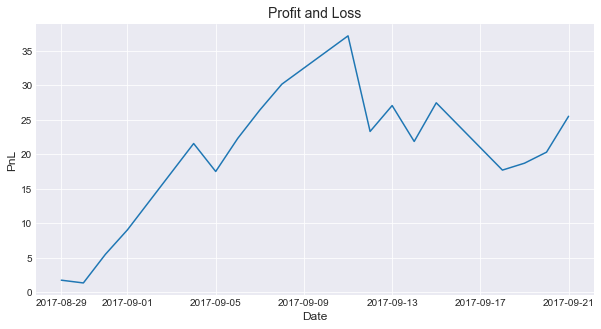

In [9]:
# Следующим шагом считется доходность по LTP_far_month и LTP_near_month отдельно.

nifty_data['far_month_pnl'] = nifty_data['LTP_far_month'] - \
    nifty_data['LTP_far_month'].shift(1)

nifty_data['near_month_pnl'] = nifty_data['LTP_near_month'] - \
    nifty_data['LTP_near_month'].shift(1)

# Следующим шагом считается общая доходность стратегии как разница между доходностями ближнего и дальнего месяца
# умноженными на сигнал. 


nifty_data['pnl'] = nifty_data.signal.shift(
    1) * (nifty_data.far_month_pnl - nifty_data.near_month_pnl)

# Далее по этому столбцу считается кумулятивная сумма. То есть накопительным итогом на каждый день.

# Plot pnl
plt.figure(figsize=(10, 5))
plt.plot(nifty_data['pnl'].cumsum())

# Set labels for the plot
plt.title('Profit and Loss', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('PnL', fontsize=12)
plt.show()

In [10]:
nifty_data['pnl']

date
2017-08-28      NaN
2017-08-29     1.75
2017-08-30    -0.40
2017-08-31     4.15
2017-09-01     3.55
2017-09-04    12.50
2017-09-05    -4.05
2017-09-06     4.80
2017-09-07     4.10
2017-09-08     3.75
2017-09-11     7.00
2017-09-12   -13.85
2017-09-13     3.75
2017-09-14    -5.20
2017-09-15     5.60
2017-09-18    -9.75
2017-09-19     1.00
2017-09-20     1.60
2017-09-21     5.20
Name: pnl, dtype: float64

In [11]:
nifty_data

,symbol,date,fut_near_month_close,fut_far_month_close,strike_price,near_month_expiry,LTP_near_month,far_month_expiry,LTP_far_month,near_month_days_to_expiry,...,IV_far_month,variance_near_month,variance_far_month,variance_diff,forward_variance_days,forward_volatility,signal,far_month_pnl,near_month_pnl,pnl
date,,,,,,,,,,,,,,,,,,,,,
2017-08-28,NIFTY,2017-08-28,9950.80,9980.65,9800,2017-09-28,226.45,2017-10-26,293.60,31,...,11.962891,12.298441,23.132971,10.834530,28,11.884269,1,NaN,NaN,NaN
2017-08-29,NIFTY,2017-08-29,9829.40,9860.15,9800,2017-09-28,150.80,2017-10-26,219.70,30,...,12.031555,11.988652,23.002692,11.014040,28,11.982315,1,-73.90,-75.65,1.75
2017-08-30,NIFTY,2017-08-30,9912.45,9939.75,9800,2017-09-28,191.20,2017-10-26,259.70,29,...,11.653900,10.461187,21.209214,10.748027,28,11.836732,-1,40.00,40.40,-0.40
2017-08-31,NIFTY,2017-08-31,9937.20,9963.35,9800,2017-09-28,201.85,2017-10-26,266.20,28,...,11.161804,9.459534,19.114545,9.655011,28,11.218733,-1,6.50,10.65,4.15
2017-09-01,NIFTY,2017-09-01,10007.30,10034.20,9800,2017-09-28,251.50,2017-10-26,312.30,27,...,11.085510,9.304343,18.517451,9.213108,28,10.958989,1,46.10,49.65,3.55
2017-09-04,NIFTY,2017-09-04,9927.65,9955.75,9800,2017-09-28,198.90,2017-10-26,272.20,24,...,12.367249,10.069322,21.789971,11.720649,28,12.360705,1,-40.10,-52.60,12.50
2017-09-05,NIFTY,2017-09-05,9971.60,9999.45,9800,2017-09-28,227.50,2017-10-26,296.75,23,...,12.173176,9.745190,20.705470,10.960280,28,11.953036,1,24.55,28.60,-4.05
2017-09-06,NIFTY,2017-09-06,9935.35,9966.00,9800,2017-09-28,202.55,2017-10-26,276.60,22,...,12.451172,9.800715,21.237217,11.436501,28,12.209954,1,-20.15,-24.95,4.80
2017-09-07,NIFTY,2017-09-07,9954.70,9987.00,9800,2017-09-28,211.65,2017-10-26,289.80,21,...,12.527466,9.059545,21.068308,12.008764,28,12.511707,1,13.20,9.10,4.10
